# Clustering: K-Means In-Depth

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

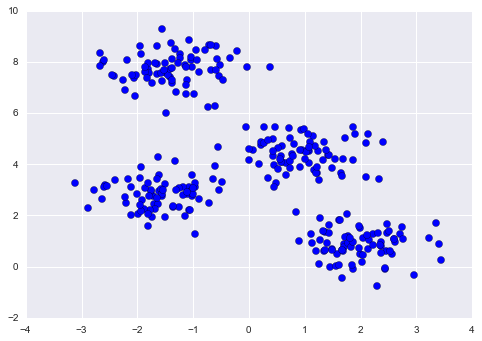

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

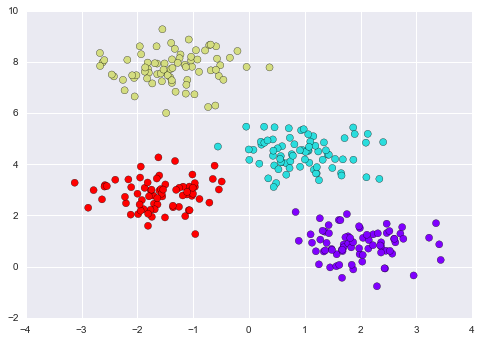

In [4]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

## The K-Means Algorithm: Expectation Maximization

K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.
*Expectation-Maximization* is a two-step approach which works as follows:

1. Guess some cluster centers
2. Repeat until converged

   1. Assign points to the nearest cluster center
   2. Set the cluster centers to the mean 
   
Let's quickly visualize this process:

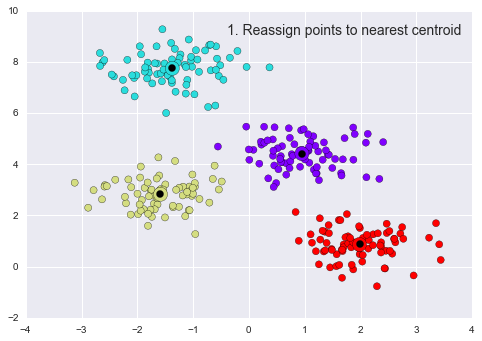

In [5]:
from fig_code import plot_kmeans_interactive
plot_kmeans_interactive();

## Application of KMeans to Digits

For a closer-to-real-world example, let's again take a look at the digits data. Here we'll use KMeans to automatically cluster the data in 64 dimensions, and then look at the cluster centers to see what the algorithm has found.

In [6]:
from sklearn.datasets import load_digits
digits = load_digits()

In [7]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

(10L, 64L)

We see ten clusters in 64 dimensions. Let's visualize each of these cluster centers to see what they represent:

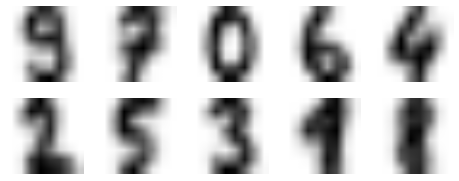

In [8]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

In [9]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

For good measure, let's use our PCA visualization and look at the true cluster labels and K-means cluster labels:

from sklearn.decomposition import PCA

X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10),
              edgecolor='none', alpha=0.6)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=labels, **kwargs)
ax[0].set_title('learned cluster labels')

ax[1].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs)
ax[1].set_title('true labels');

Just for kicks, let's see how accurate our K-Means classifier is **with no label information:**

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.79020589872008906

80% accuracy!

[[176   0   0   0   2   0   0   0   0   0]
 [  0 154  24   1   0   1   2   0   0   0]
 [  1  11 148  13   0   0   0   2   0   2]
 [  0   7   1 158   0   2   0   6   0   9]
 [  0   4   0   0 166   0   0  11   0   0]
 [  0   0   0   1   2 136   1   0   0  42]
 [  1   3   0   0   0   0 177   0   0   0]
 [  0  12   0   0   0   1   0 166   0   0]
 [  0 109   3   2   0   5   2   3   0  50]
 [  0  20   0   6   0   7   0   8   0 139]]


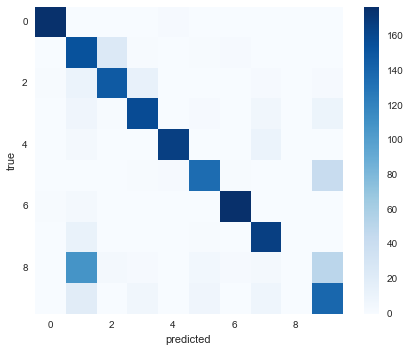

In [12]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(digits.target, labels))

plt.imshow(confusion_matrix(digits.target, labels),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

Again, this is an 80% classification accuracy for an **entirely unsupervised estimator** which knew nothing about the labels.

## Example: KMeans for Color Compression

One interesting application of clustering is in color image compression. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and conversely a large number of pixels will have similar or identical colors.

Scikit-learn has a number of images that you can play with, accessed through the datasets module. For example:

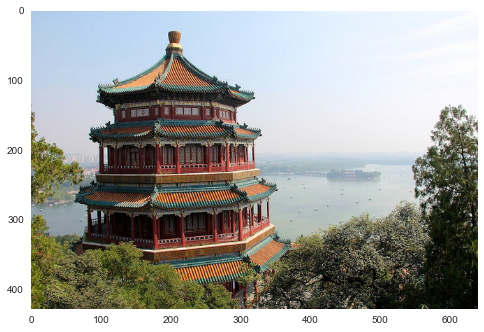

In [13]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
plt.imshow(china)
plt.grid(False);

In [14]:
china.shape

(427L, 640L, 3L)

427 by 640 pixes. 3 colors

We can envision this image as a cloud of points in a 3-dimensional color space. We'll rescale the colors so they lie between 0 and 1, then reshape the array to be a typical scikit-learn input:

In [15]:
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

(273280L, 3L)


We now have 273,280 points in 3 dimensions.
Our task is to use KMeans to compress the 2563 colors into a smaller number (say, 64 colors). Basically, we want to find Ncolor clusters in the data, and create a new image where the true input color is replaced by the color of the closest cluster.

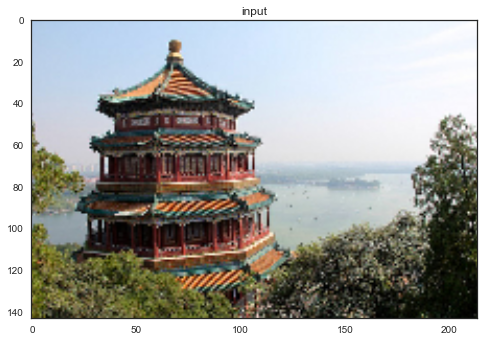

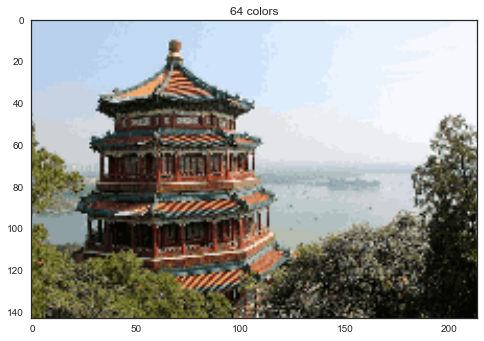

In [18]:
# reduce the size of the image for speed
image = china[::3, ::3]
n_colors = 64

X = (image / 255.0).reshape(-1, 3)
    
model = KMeans(n_colors)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(image.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image
with sns.axes_style('white'):
    plt.figure()
    plt.imshow(image)
    plt.title('input')

    plt.figure()
    plt.imshow(new_image)
    plt.title('{0} colors'.format(n_colors))

Compare the input and output image: we've reduced the $256^3$ colors to just 64.